### 로지스틱 회귀

- 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘이다

- 로지스틱이 선형 회귀와 다른 점은 학습을 통해 선형 함수의 최적선을 찾는 것이 아니라 **시그모이드 함수** 최적선을 찾고 반환값을 확률로 간주해 확률에 따라 분류를 결정하는 것

- y = 1/(1+e − x)

    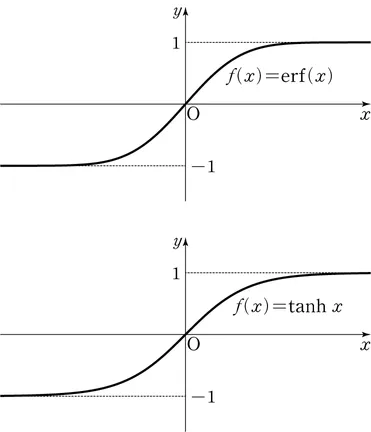

- 시그모이드 함수는 x값이 아무리 커지거나 작아져도 y값은 항상 0과 1사이를 반환한다.

- LogisticRegression 클래스의 solver 파라미터에서는 Ibfgs, liblinear, newton-cg, sag, saga 값을 적용해서 최적화를 선택할 수 있다

  - Ibfgs: 사이킷런 0.22 버전부터 solver의 기본값, 메모리 공간 절약, CPU 코어 수가 많다면 최적화를 병렬로 수행

  - liblinear: 버전 0.21까지는 얘가 기본값, 다차원, 작은 데이터셋에서 효과적으로 동작하지만 국소 최적화 이슈가 있음, 병렬 최적화 불가능

  - newton-cg: 좀 더 정교한 최적화 가능, 대용량 데이터에선 속도가 느림

  - sag: 경사하강법 기반의 최적화 적용, 대용량 데이터에서 속도가 빠름

  - saga: sag와 유사, L1 정규화 가능

- 다양한 solver값이 있지만 성능 차이는 사실 미비함. 일반적으로는 Ibfgs, liblinear를 선택함

#### 위스콘신 유방암 데이터로 실습하기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#평균 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

solver = Ibfgs로 학습하기

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score

#solver인자값을 입력하지 않고 디폴트인 Ibfgs로 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

print('accuracy: {0:.3f}, roc_auc: {1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds)))

accuracy: 0.977, roc_auc: 0.972


서로 다른 solver값으로 학습하기

solver는 최적화에 상대적으로 많은 반복 횟수가 필요할 수 있으므로 max_iter=600으로 설정

In [4]:
solvers = ['Ibfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

for solver in solvers:
  lr_clf = LogisticRegression(solver=solver, max_iter=600)
  lr_clf.fit(X_train, y_train)
  lr_preds = lr_clf.predict(X_test)

  print('solver: {0}, accuracy: {1:.3f}, roc_auc: {2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds)))

InvalidParameterError: ignored

- LogisticRegression 클래스의 또다른 주요 하이퍼파라미터로 penalty와 C가 있음

  - penalty는 규제의 유형을 설정, 기본은 L2

  - C는 규제 강도를 조절하는 alpha값의 역수. 즉, C = 1/alpha. 값이 작을수록 규제 강도가 크다

- L1, L2 규제의 경우 solver 설정에 따라 영향을 받음

   → Liblinear, saga의 경우 L1, L2 규제가 모두 가능하지만

   → Ibfgs, newton-dg, sag의 경우 L2 규제만 가능

위스콘신 데이터에서 GridSearchCV를 이용하여 solver, penalty, C를 최적화해보자

In [4]:
from sklearn.model_selection import GridSearchCV

params = {'solver': ['liblinear', 'Ibfgs'],
          'penalty': ['l1', 'l2'],
          'C': [0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터: {0}, 최적 평균 정확도: {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도: 0.979


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklear

C값은 0.1, penalty는 l2 규제, solver가 liblinear일 때 평균 정확도는 0.979로 가장 좋은 성능을 나타냄